2023年11月20日凌晨，再次尝试手攒QAOA算法。希望这次能够有一个让人满意的结果

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

现在我们要搭建一个graph, 它是我们的计算目标

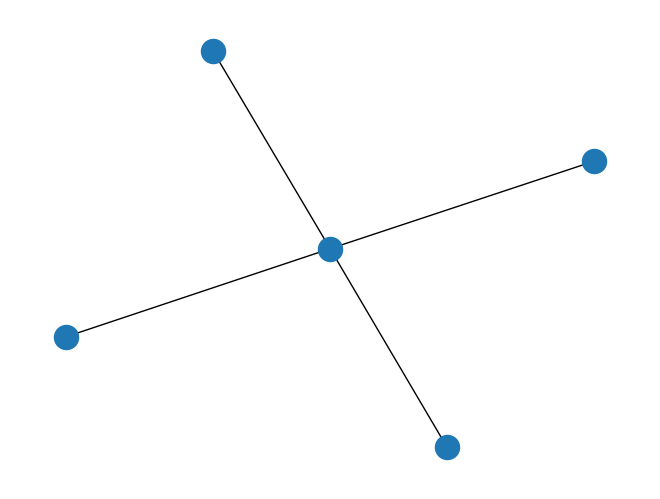

In [2]:
G=nx.Graph()
G.add_edges_from([(2,0),(2,1), (2,3), (2,4)])
nx.draw(G)


根据参考教材的步骤，我们首先建立cost operator, 也就是$e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$, 

需要注意的是，C就是那个problem hamiltonian。不在指数上的时候是hamiltonian, 和指数形式写在一起的时候就是cost operator.

In [3]:
#又来抄代码了，python 弱手伤不起啊。一行一行代码就像小孩子刚拿笔写字的时候的一笔一划一样稚嫩
def append_zz_term(qc, q1, q2, gamma):#这里我们定义append_zz_term的操作，qc是我们所操作的quantum circuit,gamma是用classical optimizer来优化的
    qc.cx(q1,q2)#这是使用q1:控制比特，q2:目标比特 进行cnot操作。
    qc.rz(2*gamma, q2)#对目标比特q2进行角度为2*gamma的旋转。
    qc.cx(q1,q2)#下图所示的第三步

def append_cost_operator_circuit(qc, G, gamma):#对circuit中的每一对node进行上述操作
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)

注意，这里是PPT里面71页前后的内容。
$e^{-i Z Z t}=e^{-i Z \otimes Z t}$

然后
$e^{-i Z \otimes Z t}|a b\rangle=e^{-i(-1)^{a \oplus b} t}|a b\rangle$

再然后：
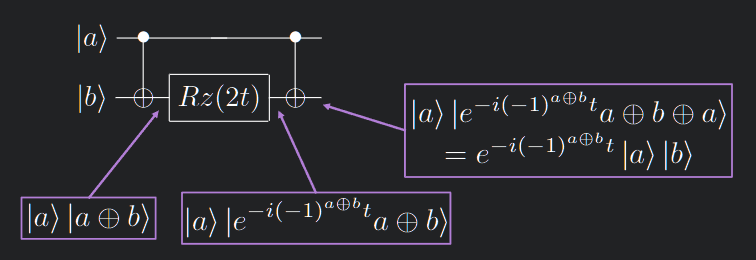

这是一个将operator 画到电路上的过程


In [4]:
N = G.number_of_nodes()#获得graph里的节点数量
qc = QuantumCircuit(N)#构建quantum circuit
append_cost_operator_circuit(qc, G, np.pi / 3)#我们定义gamma的值为pi/3，
qc.draw()#尝试画图

┌───┐┌──────────┐┌───┐                                                 »
q_0: ┤ X ├┤ Rz(2π/3) ├┤ X ├─────────────────────────────────────────────────»
     └─┬─┘└──────────┘└─┬─┘┌───┐┌──────────┐┌───┐                           »
q_1: ──┼────────────────┼──┤ X ├┤ Rz(2π/3) ├┤ X ├───────────────────────────»
       │                │  └─┬─┘└──────────┘└─┬─┘                           »
q_2: ──■────────────────■────■────────────────■────■────────────────■────■──»
                                                 ┌─┴─┐┌──────────┐┌─┴─┐  │  »
q_3: ────────────────────────────────────────────┤ X ├┤ Rz(2π/3) ├┤ X ├──┼──»
                                                 └───┘└──────────┘└───┘┌─┴─┐»
q_4: ──────────────────────────────────────────────────────────────────┤ X ├»
                                                                       └───┘»
«                      
«q_0: ─────────────────
«                      
«q_1: ─────────────────
«                      
«q_2: ──────────────■──
«                   │  
«q_3: ──────────────┼──
«     ┌──────────┐┌─┴─┐
«q_4: ┤ Rz(2π/3) ├┤ X ├
«     └──────────┘└───┘

接下来我们构建mix operator. 注意，我们有：
$e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

这里实际上就是一个简单的对每一个node进行角度为2*beta的Rx门操作

！I have a question!

(question solved)

In [5]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def append_mixer_operator_circuit(qc, G, beta):
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc

是你学艺不精了。

In [6]:
N = G.number_of_nodes()
qc = QuantumCircuit(N)
append_mixer_operator_circuit(qc, G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘

现在，对单个gate的zz append和x gate操作都定义完毕。我们开始操作整个电路


In [7]:
def get_qaoa_circuit(G, beta, gamma):#G: graph, beta&gamma:我们要优化的vector
    assert(len(beta) == len(gamma))#python中的assert:假如不满足条件，那么就会报错以及终止运行
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)#第一个N表示量子比特的数量，第二个N表示经典比特的数量
    # first, apply a layer of Hadamards(but why?why we need hadamard everywhere?)
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):#对每一个beta/gamma向量中的元素进行append操作
        append_cost_operator_circuit(qc, G, beta[i])
        append_mixer_operator_circuit(qc, G, gamma[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))#在电路中添加一个屏障, 作用是防止电路中的某些部分进行量子门操作的重新排序优化，以确保电路执行顺序不会改变
    qc.measure(range(N), range(N))
    return qc

In [8]:
#一个尝试
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

┌───┐┌───┐┌──────────┐┌───┐┌───────┐                                      »
q_0: ┤ H ├┤ X ├┤ Rz(2π/3) ├┤ X ├┤ Rx(π) ├──────────────────────────────────────»
     ├───┤└─┬─┘└──────────┘└─┬─┘└─┬───┬─┘┌──────────┐┌───┐┌───────┐            »
q_1: ┤ H ├──┼────────────────┼────┤ X ├──┤ Rz(2π/3) ├┤ X ├┤ Rx(π) ├────────────»
     ├───┤  │                │    └─┬─┘  └──────────┘└─┬─┘└───────┘            »
q_2: ┤ H ├──■────────────────■──────■──────────────────■──────■────────────────»
     ├───┤                                                  ┌─┴─┐  ┌──────────┐»
q_3: ┤ H ├──────────────────────────────────────────────────┤ X ├──┤ Rz(2π/3) ├»
     ├───┤                                                  └───┘  └──────────┘»
q_4: ┤ H ├─────────────────────────────────────────────────────────────────────»
     └───┘                                                                     »
c: 5/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                          ░ ┌─┐            
«q_0: ─────────────────────────────────────░─┤M├────────────
«                                          ░ └╥┘┌─┐         
«q_1: ─────────────────────────────────────░──╫─┤M├─────────
«                                ┌───────┐ ░  ║ └╥┘┌─┐      
«q_2: ──■────■────────────────■──┤ Rx(π) ├─░──╫──╫─┤M├──────
«     ┌─┴─┐  │   ┌───────┐    │  └───────┘ ░  ║  ║ └╥┘┌─┐   
«q_3: ┤ X ├──┼───┤ Rx(π) ├────┼────────────░──╫──╫──╫─┤M├───
«     └───┘┌─┴─┐┌┴───────┴─┐┌─┴─┐┌───────┐ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ─────┤ X ├┤ Rz(2π/3) ├┤ X ├┤ Rx(π) ├─░──╫──╫──╫──╫─┤M├
«          └───┘└──────────┘└───┘└───────┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/════════════════════════════════════════╩══╩══╩══╩══╩═
«                                             0  1  2  3  4

In [9]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

需要注意的是，qiskit的第0个qubit是从右边开始的。因此我们倒装整个电路(这里我已经遇见你会在以后遇上bug了)

In [10]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)#excute函数：执行给定的quantum circuit 对象（这里是qx）, backend用以指定我们所调用的后端
result = job.result()#excute的结果
print(invert_counts(result.get_counts()))

{'00111': 38, '01011': 38, '10010': 34, '10100': 27, '10001': 25, '00001': 36, '00010': 34, '00110': 31, '00011': 32, '11011': 32, '11111': 27, '01111': 34, '01110': 33, '01000': 37, '11100': 27, '11000': 35, '10101': 33, '01001': 36, '10111': 29, '00100': 28, '10000': 30, '01100': 29, '11110': 44, '10110': 40, '11010': 37, '11001': 27, '11101': 27, '00101': 32, '01101': 25, '01010': 36, '10011': 30, '00000': 21}


get_counts: 这里的01二进制很好理解，后面那个是被执行的次数。（之后是不是应该看做概率？）

评估excute的结果，或者说我们在尝试寻找maximize the expected objective value


下面的是code for maxcut counting , 计分器

In [11]:
# code for maxcut counting , 计分器
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('11101', G)

-1

In [12]:
def compute_maxcut_energy(counts, G):#G: graph, counts:前面所产生的若干个结果
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():#mea stands for measure, 
        obj_for_meas = maxcut_obj(meas, G)#对每个measure进行计分
        energy += obj_for_meas * meas_count#energy的定义是分数*出现次数
        total_counts += meas_count
    return energy / total_counts#分数的加权平均值

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.00390625

等于说，energy实际上就是分数的加权平均值

### Now: 组合在一起

1st step: classical optimizer 

COBYLA, soit Constrainted optimization by Linear approximation. 

在scipy里面有介绍，链接：https://docs.scipy.org/doc/scipy/reference/optimize.minimize-cobyla.html

我觉得现在关注到minimize就可以了。

In [13]:
def get_black_box_objective(G,p):#这里的p是什么意思？
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas. QUESTION: But why??
        beta = theta[:p]#这写法我真没见过.jpg。python还有多少奇奇怪怪的写法.jpg
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

OK, not a big problem. 可以理解为把前面的这些东西给结合在一起了。

之后开始用optimizer了

In [14]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])#这个init_point是怎么来的？
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':500, 'disp': True})
res_sample


   Normal return from subroutine COBYLA


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.97265625
       x: [ 7.673e-01  2.190e+00  7.086e-01  2.358e+00  5.446e-01
            2.356e+00  7.138e+00  2.199e+00  3.986e+00  6.111e+00]
    nfev: 123
   maxcv: 0.0


   NFVALS =  123   F =-3.972656E+00    MAXCV = 0.000000E+00
   X = 7.673478E-01   2.189676E+00   7.085658E-01   2.358045E+00   5.446310E-01
       2.356442E+00   7.137847E+00   2.198957E+00   3.986239E+00   6.111033E+00


计算部分基本完成了。接下来就是一些输出和前端的事情了。


In [15]:
optimal_theta = res_sample['x']# optimal_theta 只是一个非常intermediate的东西，它是我们给优化结果取的一个名称。
                               #res_sample是我们已经优化过的结果
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts#（这个单纯是用来输出的。你对python还是太不熟悉了）

{'00110': 1,
 '11011': 494,
 '10011': 2,
 '00100': 504,
 '11001': 3,
 '00101': 3,
 '11010': 3,
 '01100': 3,
 '10100': 4,
 '01011': 2,
 '10010': 1,
 '10101': 1,
 '01001': 1,
 '11101': 1,
 '00111': 1}

### 这些结果好吗？


<BarContainer object of 4 artists>

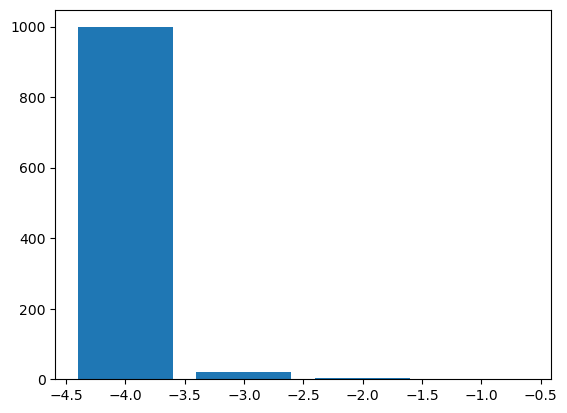

In [16]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

（计算各种结果的energy）

Best string: 11011 with cut: 4


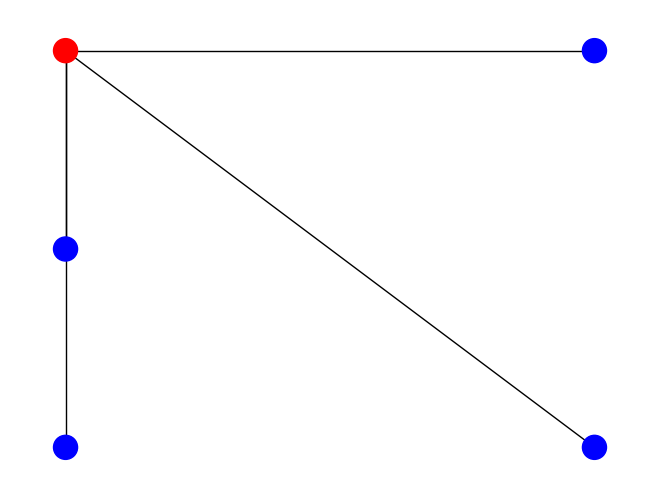

In [17]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

我觉得这一段代码我之后应该会处于一个能抄就抄的状态qaq. 不过我们可以掠过一些细节。